In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Classifier-free Guidance Diffusion Model

In [24]:
import math
from abc import abstractmethod
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

## Utilities Class

### Noise Schedular

In [25]:
# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def sigmoid_beta_schedule(timesteps):
    betas = torch.linspace(-6, 6, timesteps)
    betas = torch.sigmoid(betas)/(betas.max()-betas.min())*(0.02-betas.min())/10
    return betas

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

## Unet

### Utility Modules

In [26]:
# function return timestep_embedding
import math
from abc import abstractmethod

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [27]:
def timestep_embedding(timesteps, # scalar timestep (batch,)
                       dim, # time embedding dimension
                       max_period=10000
                       ) -> torch.Tensor:
    assert dim % 2 == 0, "time embedding must be divisible by 2"
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [28]:
# define TimestepEmbedSequential to support `time_emb` as extra input
class TimestepBlock(nn.Module):
    @abstractmethod
    def foward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    def forward(self, x, t_emb, c_emb, mask):
        for layer in self:
            if(isinstance(layer, TimestepBlock)):
                x = layer(x, t_emb, c_emb, mask)
            else:
                x = layer(x)
        return x

def norm_layer(ch):
    return nn.GroupNorm(32, ch)

In [29]:
# Residual block
class Residual_block(TimestepBlock):
    def __init__(self, in_ch, out_ch, time_ch, class_ch, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_ch),
            nn.SiLU(),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        )

        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_ch, out_ch)
        )

        self.class_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(class_ch, out_ch)
        )


        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_ch, out_ch)
        )

        self.conv2 = nn.Sequential(
            norm_layer(out_ch),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        )

        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, kernel_size=1)
        else:
            self.shortcut = nn.Identity()

    def forward(self,
                x, # (batch_size, in_dim, h, w)
                t, # (batch_size, time_dim)
                c, # (batch_size, class_dim)
                mask # (batch_size,)
                ):
        h = self.conv1(x)
        emb_t = self.time_emb(t)
        emb_c = self.class_emb(c)*mask[:, None]
        h += (emb_t[:,:, None, None] + emb_c[:,:, None, None])
        h = self.conv2(h)

        return h + self.shortcut(x)

In [30]:
# Attention block with shortcut
class AttentionBlock(nn.Module):
    def __init__(self, ch, num_heads=1):
        super().__init__()
        self.num_heads = num_heads
        assert ch % num_heads == 0

        self.norm = norm_layer(ch)
        self.qkv = nn.Conv2d(ch, ch * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(ch, ch, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x

In [31]:
# upsample
class Upsample(nn.Module):
    def __init__(self, ch, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(ch, ch, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

# downsample
class Downsample(nn.Module):
    def __init__(self, ch, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(ch, ch, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)

### Unet

In [32]:
class UnetModel(nn.Module):
    def __init__(self,
                 in_ch=3,
                 model_ch=128,
                 out_ch=3,
                 num_res_blocks=2,
                 attention_resolutions=(8,16),
                 dropout=0,
                 channel_mult=(1,2,2,2),
                 conv_resample=True,
                 num_heads=4,
                 class_num=10
                ):
        super().__init__()
        self.in_ch = in_ch
        self.model_ch = model_ch
        self.out_ch = out_ch
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        self.class_num = class_num

        #time embedding
        time_emb_dim = model_ch*4
        self.time_emb = nn.Sequential(
                nn.Linear(model_ch, time_emb_dim),
                nn.SiLU(),
                nn.Linear(time_emb_dim, time_emb_dim)
        )

        #class embedding
        class_emb_dim = model_ch
        self.class_emb = nn.Embedding(class_num, class_emb_dim)

        #down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_ch, model_ch, kernel_size=3, padding=1))
        ])
        down_block_ch = [model_ch]
        ch = model_ch
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [Residual_block(ch, model_ch*mult, time_emb_dim, class_emb_dim, dropout)]
                ch = model_ch*mult

                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_ch.append(ch)

            if level != len(channel_mult)-1: # do not downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_ch.append(ch)
                ds*=2

        #middle blocks
        self.middle_blocks = TimestepEmbedSequential(
            Residual_block(ch, ch, time_emb_dim, class_emb_dim, dropout),
            AttentionBlock(ch, num_heads),
            Residual_block(ch, ch, time_emb_dim, class_emb_dim, dropout)
        )

        #up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in enumerate(channel_mult[::-1]):
            for i in range(num_res_blocks+1):
                layers = [
                    Residual_block(ch+down_block_ch.pop(), model_ch*mult,\
                                   time_emb_dim, class_emb_dim, dropout)]

                ch = model_ch*mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads))

                if level!=len(channel_mult)-1 and i==num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(ch, out_ch, kernel_size=3, padding=1)
        )

    def forward(self, x, timesteps, c, mask):

        hs = []
        # time step and class embedding
        t_emb = self.time_emb(timestep_embedding(timesteps, dim=self.model_ch))
        c_emb = self.class_emb(c)


        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, t_emb, c_emb, mask)
#             print(h.shape)
            hs.append(h)

        # middle stage
        h = self.middle_blocks(h, t_emb, c_emb, mask)

        # up stage
        for module in self.up_blocks:
#             print(h.shape, hs[-1].shape)
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, t_emb, c_emb, mask)

        return self.out(h)

## Diffusion Model with DDPM and DDIM

In [41]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        elif beta_schedule == 'sigmoid':
            betas = sigmoid_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas

        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)

        # calculations parameters for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )

        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )

    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out

    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, c, w, clip_denoised=True):
        device = next(model.parameters()).device
        batch_size = x_t.shape[0]
        # predict noise using model
        pred_noise_c = model(x_t, t, c, torch.ones(batch_size).int().to(device))
        pred_noise_none = model(x_t, t, c, torch.zeros(batch_size).int().to(device))
        pred_noise = (1+w)*pred_noise_c - w*pred_noise_none

        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance

    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, c, w, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t,
                                                c, w, clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img

    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape, n_class=10, w=2, mode='random', clip_denoised=True):
        batch_size = shape[0]
        device = next(model.parameters()).device

        # generate labels
        if mode == 'random': # random gnerate new image
            cur_y = torch.randint(0, n_class, (batch_size,)).to(device)
        elif mode == 'all':  # generate new image from 0 to 9
            if batch_size%n_class!=0:
                batch_size = n_class
                print('change batch_size to', n_class)
            cur_y = torch.tensor([x for x in range(n_class)]*(batch_size//n_class), dtype=torch.long).to(device)
        else:
            cur_y = torch.ones(batch_size).long().to(device)*int(mode)

        # start from pure noise
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long), cur_y, w, clip_denoised)
            imgs.append(img.cpu().numpy())
        return imgs

    # sample new images
    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, ch=3, n_class=10, w=2, mode='random', clip_denoised=True):
        return self.p_sample_loop(model, (batch_size, ch, image_size, image_size), n_class, w, mode, clip_denoised)

    # use ddim to sample
    @torch.no_grad()
    def ddim_sample(
        self,
        model,
        image_size,
        batch_size=8,
        ch=3,
        ddim_timesteps=50,
        n_class = 10,
        w = 2,
        mode= 'random',
        ddim_discr_method="uniform",
        ddim_eta=0.0,
        clip_denoised=True):

        # get ddim time step, the subset timestep of ddpm
        if ddim_discr_method == 'uniform':
            c = self.timesteps // ddim_timesteps
            ddim_timestep_seq = np.asarray(list(range(0, self.timesteps, c)))
        elif ddim_discr_method == 'quad':
            ddim_timestep_seq = (
                (np.linspace(0, np.sqrt(self.timesteps * .8), ddim_timesteps)) ** 2
            ).astype(int)
        else:
            raise NotImplementedError(f'There is no ddim discretization method called "{ddim_discr_method}"')
        # add one to get the final alpha values right
        ddim_timestep_seq = ddim_timestep_seq + 1
        # previous sequence
        ddim_timestep_prev_seq = np.append(np.array([0]), ddim_timestep_seq[:-1])

        device = next(model.parameters()).device

        # generate labels
        if mode == 'random': # generate random image
            cur_y = torch.randint(0, n_class, (batch_size,)).to(device)
        elif mode == 'all': # generate all image frm 0 to 9
            if batch_size%n_class!=0:
                batch_size = n_class
                print('change batch_size to', n_class)
            cur_y = torch.tensor([x for x in range(n_class)]*(batch_size//n_class), dtype=torch.long).to(device)
        else:
            cur_y = torch.ones(batch_size).long().to(device)*int(mode)

        # start from pure noise
        sample_img = torch.randn((batch_size, ch, image_size, image_size), device=device)
        seq_img = [sample_img.cpu().numpy()]

        for i in tqdm(reversed(range(0, ddim_timesteps)), desc='sampling loop time step', total=ddim_timesteps):
            t = torch.full((batch_size,), ddim_timestep_seq[i], device=device, dtype=torch.long)
            prev_t = torch.full((batch_size,), ddim_timestep_prev_seq[i], device=device, dtype=torch.long)

            # 1. get current and previous alpha_cumprod
            alpha_cumprod_t = self._extract(self.alphas_cumprod, t, sample_img.shape)
            alpha_cumprod_t_prev = self._extract(self.alphas_cumprod, prev_t, sample_img.shape)

            # 2. predict noise using model
            pred_noise_c = model(sample_img, t, cur_y, torch.ones(batch_size).int().cuda())
            pred_noise_none = model(sample_img, t, cur_y, torch.zeros(batch_size).int().cuda())
            pred_noise = (1+w)*pred_noise_c - w*pred_noise_none # pred noise with condition - pred noise no cond
            # this lead to the idea of postive prompt and negative prompt

            # 3. get the predicted x_0
            pred_x0 = (sample_img - torch.sqrt((1. - alpha_cumprod_t)) * pred_noise) / torch.sqrt(alpha_cumprod_t)
            if clip_denoised:
                pred_x0 = torch.clamp(pred_x0, min=-1., max=1.)

            # 4. compute variance sigma_t, when sigma_t = 0, ddim become deterministic
            sigmas_t = ddim_eta * torch.sqrt(
                (1 - alpha_cumprod_t_prev) / (1 - alpha_cumprod_t) * (1 - alpha_cumprod_t / alpha_cumprod_t_prev))

            # 5. compute "direction pointing to x_t"
            pred_dir_xt = torch.sqrt(1 - alpha_cumprod_t_prev - sigmas_t**2) * pred_noise

            # 6. compute x_{t-1}
            x_prev = torch.sqrt(alpha_cumprod_t_prev) * pred_x0 + pred_dir_xt + sigmas_t * torch.randn_like(sample_img)

            sample_img = x_prev
            if mode == 'all':
                seq_img.append(sample_img.cpu().numpy())

        if mode == 'all':
            return seq_img
        else:
            return sample_img.cpu().numpy()

    # compute train losses
    def train_losses(self, model, x_start, t, c, mask_c):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t, c, mask_c)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

## Training

In [34]:
batch_size = 128
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST(root='./dataset/mnist/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UnetModel(
    in_ch=1,
    model_ch=96,
    out_ch=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
    class_num=10
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)

In [35]:
image = next(iter(train_loader))[0][0].squeeze()
label = next(iter(train_loader))[1][0].squeeze()

x_start = image

# initialize diffusion
gaussian_diffusion = GaussianDiffusion(timesteps=500, beta_schedule='linear')

In [36]:
# train
epochs = 15
p_uncound = 0.15
len_data = len(train_loader)
time_end = time.time()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(epochs):
    for step, (images, labels) in enumerate(train_loader):
        time_start = time_end

        optimizer.zero_grad()

        batch_size = images.shape[0]
        images = images.to(device)
        labels = labels.to(device)

        # random generate mask with probabilistic p_uncond
        z_uncound = torch.rand(batch_size)
        batch_mask = (z_uncound>p_uncound).int().to(device)

        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = gaussian_diffusion.train_losses(model, images, t, labels, batch_mask)

        if step % 100 == 0:
            time_end = time.time()
            print("Epoch{}/{}\t  Step{}/{}\t Loss {:.4f}\t Time {:.2f}".format(epoch+1, epochs, step+1, len_data, loss.item(), time_end-time_start))

        loss.backward()
        optimizer.step()

Epoch1/15	  Step1/469	 Loss 1.1049	 Time 0.35
Epoch1/15	  Step101/469	 Loss 0.0616	 Time 48.22
Epoch1/15	  Step201/469	 Loss 0.0394	 Time 45.34
Epoch1/15	  Step301/469	 Loss 0.0391	 Time 46.56
Epoch1/15	  Step401/469	 Loss 0.0373	 Time 46.05
Epoch2/15	  Step1/469	 Loss 0.0314	 Time 31.74
Epoch2/15	  Step101/469	 Loss 0.0354	 Time 46.46
Epoch2/15	  Step201/469	 Loss 0.0246	 Time 46.45
Epoch2/15	  Step301/469	 Loss 0.0268	 Time 46.39
Epoch2/15	  Step401/469	 Loss 0.0307	 Time 46.28
Epoch3/15	  Step1/469	 Loss 0.0325	 Time 31.77
Epoch3/15	  Step101/469	 Loss 0.0229	 Time 46.28
Epoch3/15	  Step201/469	 Loss 0.0351	 Time 46.27
Epoch3/15	  Step301/469	 Loss 0.0227	 Time 46.24
Epoch3/15	  Step401/469	 Loss 0.0261	 Time 46.26
Epoch4/15	  Step1/469	 Loss 0.0236	 Time 31.79
Epoch4/15	  Step101/469	 Loss 0.0224	 Time 46.31
Epoch4/15	  Step201/469	 Loss 0.0266	 Time 46.33
Epoch4/15	  Step301/469	 Loss 0.0239	 Time 46.43
Epoch4/15	  Step401/469	 Loss 0.0195	 Time 46.45
Epoch5/15	  Step1/469	 Loss 0

In [37]:
save_path = "/content/drive/MyDrive/Phase 2/CFG/unet_mnist.pth"
torch.save(model.state_dict(), save_path)

In [44]:
# load pretrained model
save_path = "/content/drive/MyDrive/Phase 2/CFG/unet_mnist.pth"
model = UnetModel(
    in_ch=1,
    model_ch=96,
    out_ch=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[],
    class_num=10
)
# Load the saved state dictionary into the model instance
model.load_state_dict(torch.load(save_path))
# Move model to the device
model.to(device)


gaussian_diffusion = GaussianDiffusion(timesteps=500, beta_schedule='linear')

### DDPM

sampling loop time step: 100%|██████████| 500/500 [01:17<00:00,  6.46it/s]


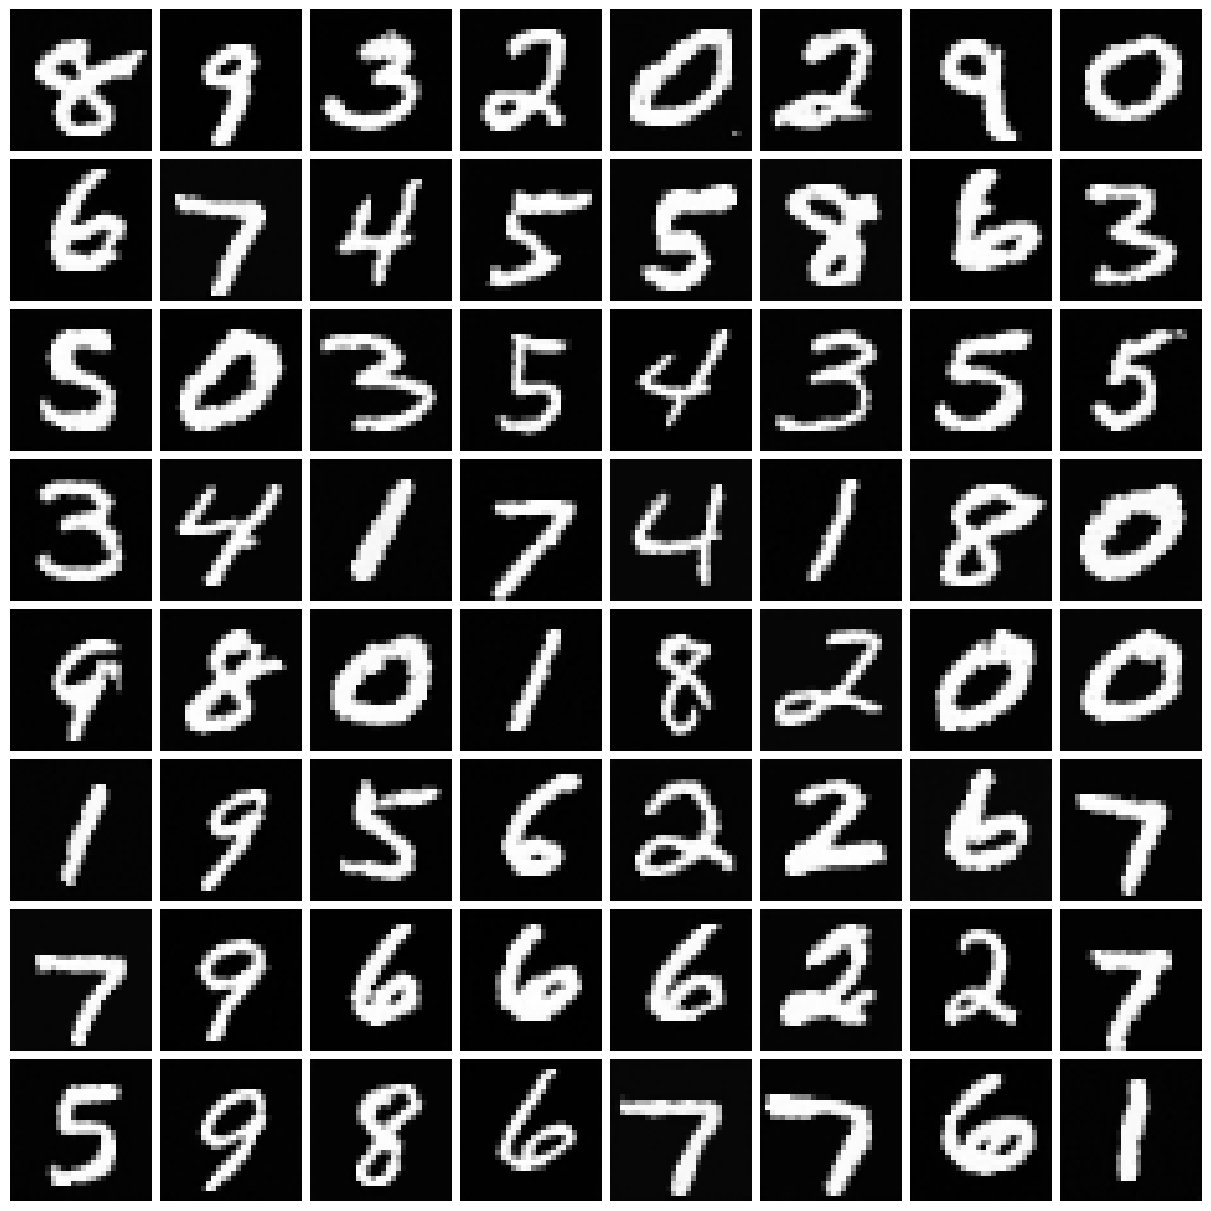

In [45]:
# generate random  mnist images using DDPM
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, ch=1, n_class=10, w=2, mode='random', clip_denoised=False)

fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

### DDIM

In [46]:
ddim_generated_images = gaussian_diffusion.ddim_sample(model, 28, batch_size=64, ch=1, ddim_timesteps=50, n_class=10,
                                                       w=2, mode='random', ddim_discr_method='quad', ddim_eta=0.0, clip_denoised=False)
# 00:07 compare to ddpm 1:17

sampling loop time step: 100%|██████████| 50/50 [00:07<00:00,  6.49it/s]


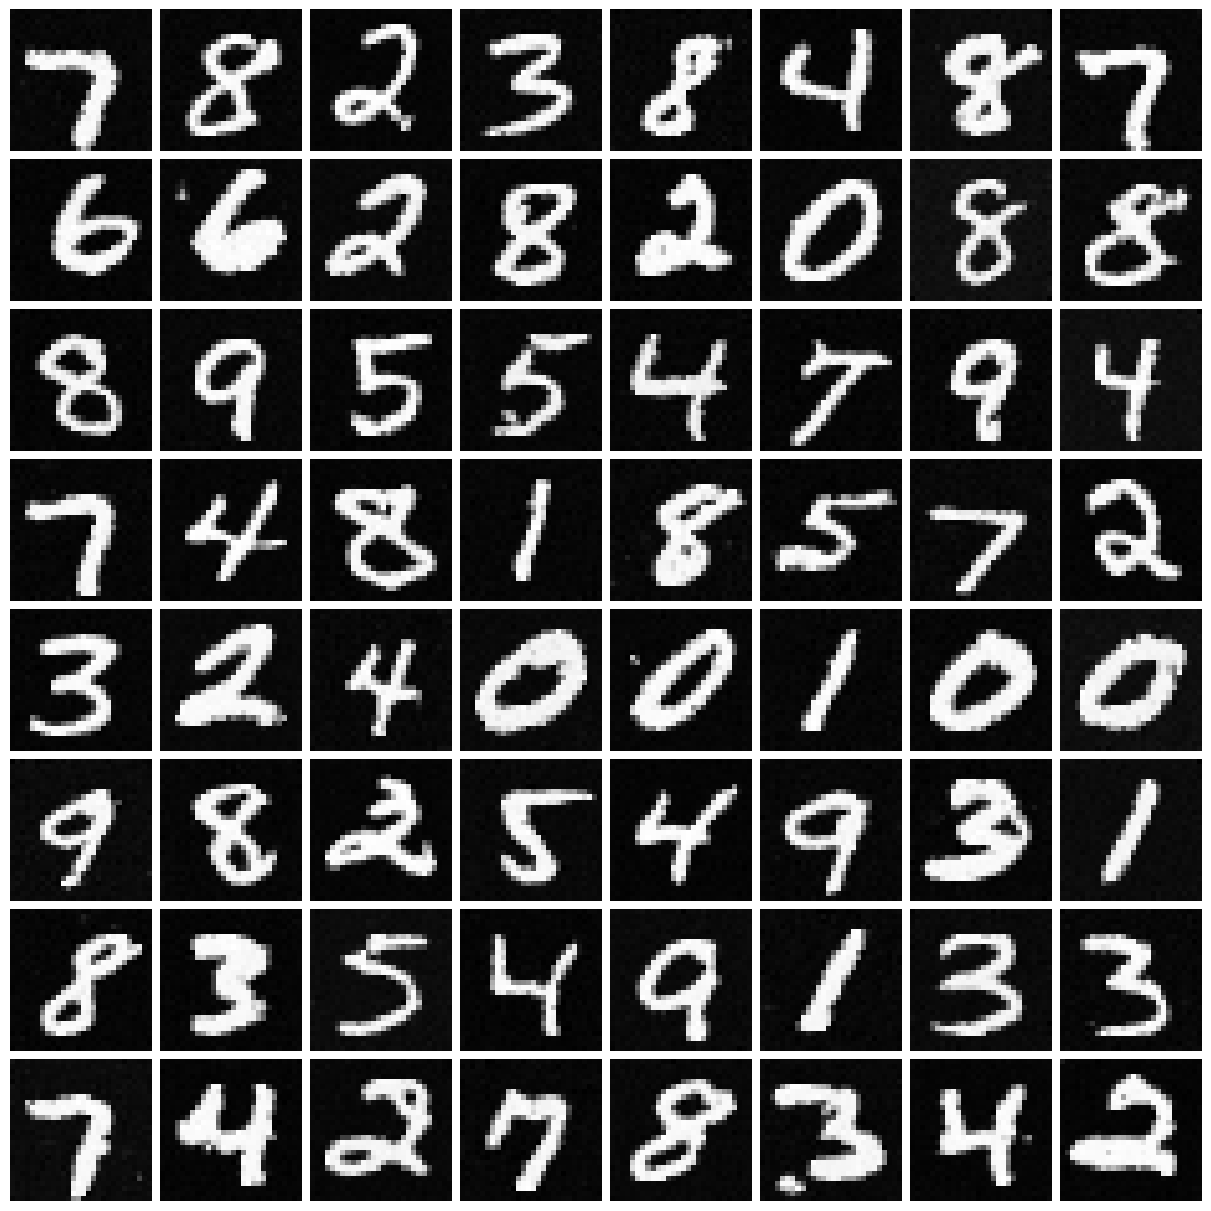

In [47]:
# ddim generate random new mnist images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = ddim_generated_images.reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

In [48]:
gif_generated_images = gaussian_diffusion.ddim_sample(model, 28, batch_size=40, ch=1, ddim_timesteps=100, n_class=10,
                                                       w=2, mode='all', ddim_discr_method='quad', ddim_eta=0.0, clip_denoised=False)

sampling loop time step: 100%|██████████| 100/100 [00:11<00:00,  8.72it/s]


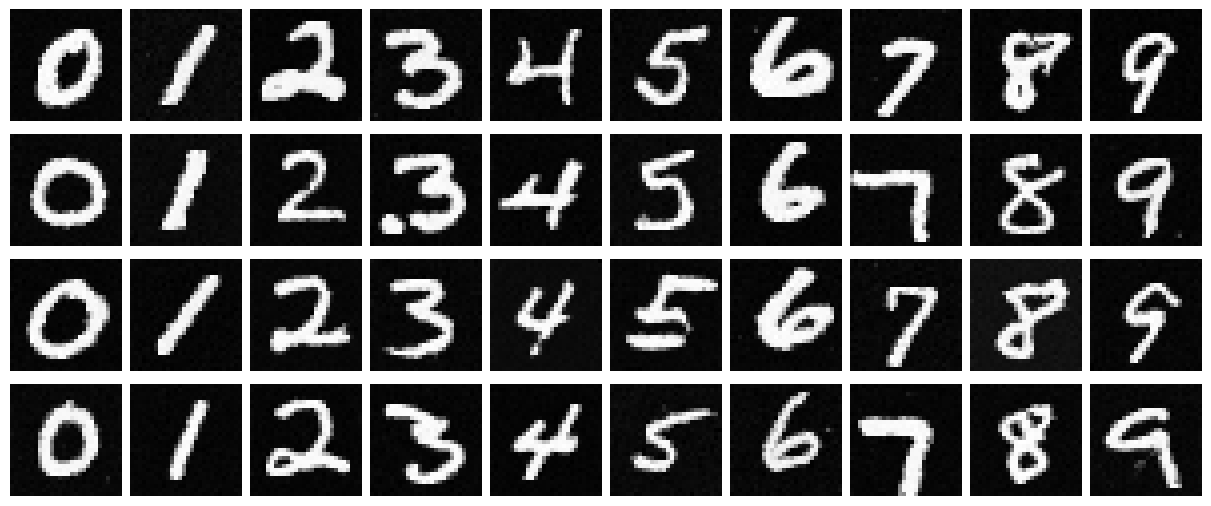

In [49]:
# ddim generate new mnist image from 0 to 9
fig = plt.figure(figsize=(12, 5), constrained_layout=True)
gs = fig.add_gridspec(4, 10)

imgs = gif_generated_images[-1].reshape(4, 10, 28, 28)
for n_row in range(4):
    for n_col in range(10):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")